<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/nano/notebooks/hpo/custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

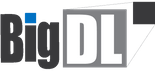

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built by subclassing tensorflow.keras.Model.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.

In [1]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1
!source bigdl-nano-init

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [4]:
import bigdl.nano.automl as automl
import bigdl.nano.automl.hpo as hpo
automl.hpo_config.enable_hpo_tf()

# Step2: Prepare data
We use fashion MNIST dataset for demonstration.

In [5]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

CLASSES = 10

img_x, img_y = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

# Step3: Build model and specify search spaces
We now create our model. 

Decorate the model class with hpo.tfmodel, and you will be able to specify search spaces in init arguments when creating the model, as shown below. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).


In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [7]:
import tensorflow as tf
@hpo.tfmodel()
class MyModel(tf.keras.Model):

    def __init__(self, filters, kernel_size, strides, activation):
        super().__init__()
        self.conv1 = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation)
        self.pool1 = MaxPooling2D(pool_size=2)
        self.drop1 = Dropout(0.3)
        self.flat = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.drop3 = Dropout(0.5)
        self.dense2 = Dense(CLASSES, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.drop3(x)
        x = self.dense2(x)
        return x
model = MyModel(
    filters=hpo.space.Categorical(32, 64),
    kernel_size=hpo.space.Categorical(2, 4),
    strides=hpo.space.Categorical(1, 2),
    activation=hpo.space.Categorical("relu", "linear")
)

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics. If you want to tune learning rate and batch size, refer to [user guide](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html#search-the-learning-rate).

In [8]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"],
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. Use `n_parallels` to set the nubmer of parallel processes to run trials. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).

In [9]:
%%time
from bigdl.nano.automl.hpo.backend import PrunerType
model.search(
    n_trials=5,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
)

[I 2022-06-13 06:23:34,502] A new study created in memory with name: no-name-a06257c6-a349-4645-a030-4dfd3afabbe9


Starting a new tuning
Epoch 1/5
375/375 - 47s - loss: 0.5125 - accuracy: 0.8188 - val_loss: 0.3521 - val_accuracy: 0.8740 - 47s/epoch - 125ms/step
Epoch 2/5
375/375 - 45s - loss: 0.3523 - accuracy: 0.8741 - val_loss: 0.3122 - val_accuracy: 0.8877 - 45s/epoch - 121ms/step
Epoch 3/5
375/375 - 45s - loss: 0.3117 - accuracy: 0.8886 - val_loss: 0.2945 - val_accuracy: 0.8926 - 45s/epoch - 119ms/step
Epoch 4/5
375/375 - 44s - loss: 0.2822 - accuracy: 0.8977 - val_loss: 0.2819 - val_accuracy: 0.8988 - 44s/epoch - 118ms/step
Epoch 5/5
375/375 - 44s - loss: 0.2662 - accuracy: 0.9028 - val_loss: 0.2744 - val_accuracy: 0.8974 - 44s/epoch - 118ms/step


[I 2022-06-13 06:27:57,262] Trial 0 finished with value: 0.8987500071525574 and parameters: {'activation▁choice': 1, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 0 with value: 0.8987500071525574.


Epoch 1/5
375/375 - 25s - loss: 0.5594 - accuracy: 0.8027 - val_loss: 0.3800 - val_accuracy: 0.8586 - 25s/epoch - 68ms/step
Epoch 2/5


[I 2022-06-13 06:28:46,633] Trial 1 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 49s - loss: 0.5525 - accuracy: 0.8068 - val_loss: 0.3561 - val_accuracy: 0.8711 - 49s/epoch - 132ms/step
Epoch 2/5


[I 2022-06-13 06:30:25,527] Trial 2 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 23s - loss: 0.5466 - accuracy: 0.8076 - val_loss: 0.3785 - val_accuracy: 0.8598 - 23s/epoch - 61ms/step
Epoch 2/5


[I 2022-06-13 06:31:10,345] Trial 3 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 23s - loss: 0.5315 - accuracy: 0.8111 - val_loss: 0.3743 - val_accuracy: 0.8633 - 23s/epoch - 61ms/step
Epoch 2/5
375/375 - 22s - loss: 0.3656 - accuracy: 0.8678 - val_loss: 0.3231 - val_accuracy: 0.8813 - 22s/epoch - 60ms/step
Epoch 3/5
375/375 - 23s - loss: 0.3223 - accuracy: 0.8836 - val_loss: 0.3039 - val_accuracy: 0.8891 - 23s/epoch - 60ms/step
Epoch 4/5
375/375 - 22s - loss: 0.2966 - accuracy: 0.8928 - val_loss: 0.2862 - val_accuracy: 0.8982 - 22s/epoch - 58ms/step
Epoch 5/5
375/375 - 21s - loss: 0.2772 - accuracy: 0.9000 - val_loss: 0.2834 - val_accuracy: 0.8991 - 21s/epoch - 57ms/step


[I 2022-06-13 06:33:32,998] Trial 4 finished with value: 0.8990833163261414 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 4 with value: 0.8990833163261414.


Epoch 1/5
375/375 - 46s - loss: 0.4967 - accuracy: 0.8263 - val_loss: 0.3656 - val_accuracy: 0.8668 - 46s/epoch - 123ms/step
Epoch 2/5


[I 2022-06-13 06:35:03,528] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 17s - loss: 0.6242 - accuracy: 0.7772 - val_loss: 0.4095 - val_accuracy: 0.8489 - 17s/epoch - 46ms/step
Epoch 2/5


[I 2022-06-13 06:36:30,374] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 16s - loss: 0.6435 - accuracy: 0.7701 - val_loss: 0.4344 - val_accuracy: 0.8454 - 16s/epoch - 43ms/step
Epoch 2/5


[I 2022-06-13 06:37:09,168] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 23s - loss: 0.5235 - accuracy: 0.8152 - val_loss: 0.3697 - val_accuracy: 0.8642 - 23s/epoch - 60ms/step
Epoch 2/5
375/375 - 21s - loss: 0.3604 - accuracy: 0.8696 - val_loss: 0.3096 - val_accuracy: 0.8859 - 21s/epoch - 57ms/step
Epoch 3/5
375/375 - 22s - loss: 0.3195 - accuracy: 0.8853 - val_loss: 0.3092 - val_accuracy: 0.8863 - 22s/epoch - 59ms/step
Epoch 4/5


[I 2022-06-13 06:38:47,065] Trial 8 pruned. Trial was pruned at epoch 3.


Epoch 1/5
375/375 - 48s - loss: 0.5310 - accuracy: 0.8099 - val_loss: 0.3456 - val_accuracy: 0.8758 - 48s/epoch - 129ms/step
Epoch 2/5
375/375 - 49s - loss: 0.3563 - accuracy: 0.8725 - val_loss: 0.3082 - val_accuracy: 0.8908 - 49s/epoch - 131ms/step
Epoch 3/5
375/375 - 48s - loss: 0.3148 - accuracy: 0.8851 - val_loss: 0.2993 - val_accuracy: 0.8919 - 48s/epoch - 127ms/step
Epoch 4/5


[I 2022-06-13 06:41:59,637] Trial 9 pruned. Trial was pruned at epoch 3.


CPU times: user 23min 23s, sys: 7min 46s, total: 31min 9s
Wall time: 18min 25s


In [10]:
print(model.search_summary())

Number of finished trials: 10
Best trial:
  Value: 0.8990833163261414
  Params: 
    activation▁choice: 1
    filters▁choice: 0
    kernel_size▁choice: 1
    strides▁choice: 0


In [ ]:
study = model.search_summary()
study.trials_dataframe(attrs=("number", "value", "params", "state"))

# Step 6: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
375/375 [==============================] - 26s 67ms/step - loss: 0.5505 - accuracy: 0.8066 - val_loss: 0.3706 - val_accuracy: 0.8658
Epoch 2/5
375/375 [==============================] - 25s 66ms/step - loss: 0.3666 - accuracy: 0.8669 - val_loss: 0.3217 - val_accuracy: 0.8813
Epoch 3/5
375/375 [==============================] - 24s 65ms/step - loss: 0.3244 - accuracy: 0.8840 - val_loss: 0.2989 - val_accuracy: 0.8913
Epoch 4/5
375/375 [==============================] - 24s 64ms/step - loss: 0.2991 - accuracy: 0.8914 - val_loss: 0.2910 - val_accuracy: 0.8930
Epoch 5/5
375/375 [==============================] - 25s 67ms/step - loss: 0.2839 - accuracy: 0.8970 - val_loss: 0.2779 - val_accuracy: 0.8999
313/313 - 2s - loss: 0.2883 - accuracy: 0.8949 - 2s/epoch - 5ms/step
Test loss: 0.28826311230659485
Test accuracy: 0.8949000239372253


Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [12]:
print(model.summary())

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           multiple                  544       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  1179904   
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                        